<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/original_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import time
import psutil
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import keras.backend as K
import h5py
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc
from sklearn.metrics import precision_score # Import precision_score here
import tensorflow_addons as tfa
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [8]:
# 시드 설정
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 환경 변수 설정 (결정론적 연산 보장)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [9]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_data'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            data = pd.read_csv(file_path, header=None).values
            data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, data.shape[1])
            data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
            X.append(data)
            y.append(category)
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [10]:
def create_model():
    model = Sequential(name='CNN_Model')
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2]), name='conv1'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool1'))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='conv2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool2'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.0001), name='dense1'))  # Dense 레이어에 L2 정규화
    model.add(Dropout(0.3, name='dropout'))
    model.add(Dense(len(categories), activation='softmax', name='output'))

    return model

# Create and compile the model
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/10
219/219 [==============================] - 81s 366ms/step - loss: 1.5083 - accuracy: 0.4840 - val_loss: 1.2044 - val_accuracy: 0.5869
Epoch 2/10
219/219 [==============================] - 79s 362ms/step - loss: 1.0281 - accuracy: 0.5411 - val_loss: 0.4756 - val_accuracy: 0.7347
Epoch 3/10
219/219 [==============================] - 80s 363ms/step - loss: 0.6476 - accuracy: 0.7187 - val_loss: 0.2616 - val_accuracy: 0.9875
Epoch 4/10
219/219 [==============================] - 80s 363ms/step - loss: 0.5867 - accuracy: 0.7287 - val_loss: 0.2967 - val_accuracy: 0.9687
Epoch 5/10
219/219 [==============================] - 81s 369ms/step - loss: 0.5598 - accuracy: 0.7233 - val_loss: 0.2426 - val_accuracy: 0.9687
Epoch 6/10
219/219 [==============================] - 81s 372ms/step - loss: 0.5419 - accuracy: 0.7307 - val_loss: 0.4985 - val_accuracy: 0.7488
Epoch 7/10
219/219 [==============================] - 81s 372ms/step - loss: 0.5428 - accuracy: 0.7290 - val_loss: 0.2232 - val_ac

In [12]:
# 원본 모델 저장
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# 모델 사이즈 측정
model_size = os.path.getsize('model.h5') / (1024 * 1024)
print(f"Model Size: {model_size:.2f} MB")

Model Size: 439.50 MB


In [14]:
# 검증 데이터 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val_categorical)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

40/40 [==============================] - 3s 71ms/step - loss: 0.1372 - accuracy: 0.9710
Validation Loss: 0.1372
Validation Accuracy: 0.9710


In [15]:
# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

40/40 [==============================] - 3s 70ms/step - loss: 0.1346 - accuracy: 0.9734
Test Loss: 0.1346
Test Accuracy: 0.9734


In [18]:
# 혼동 행렬 및 성능 지표 출력 (테스트 데이터)
y_pred_categorical_original = model.predict(X_test) # Add this line to calculate predictions
y_pred = np.argmax(y_pred_categorical_original, axis=1)
conf_matrix_test = confusion_matrix(y_test_encoded, y_pred)

40/40 [==============================] - 3s 68ms/step


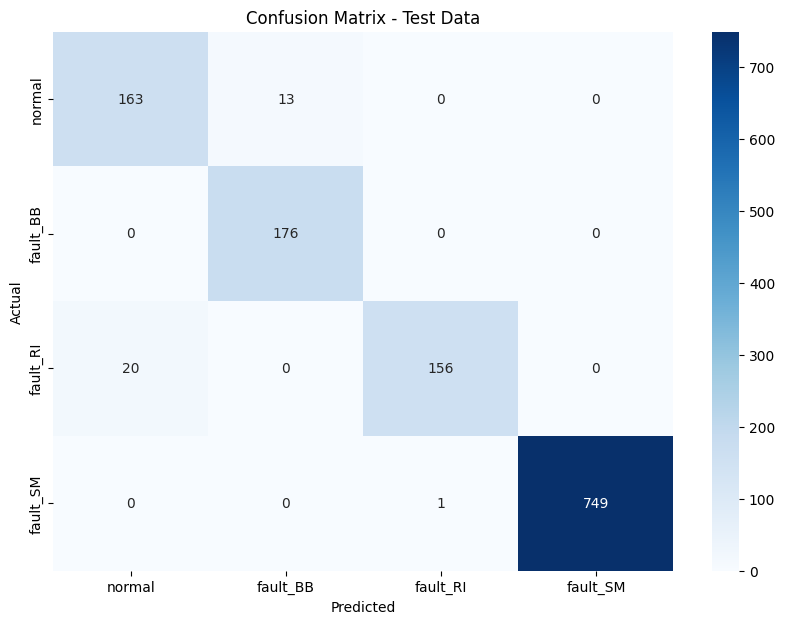

In [19]:
# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()

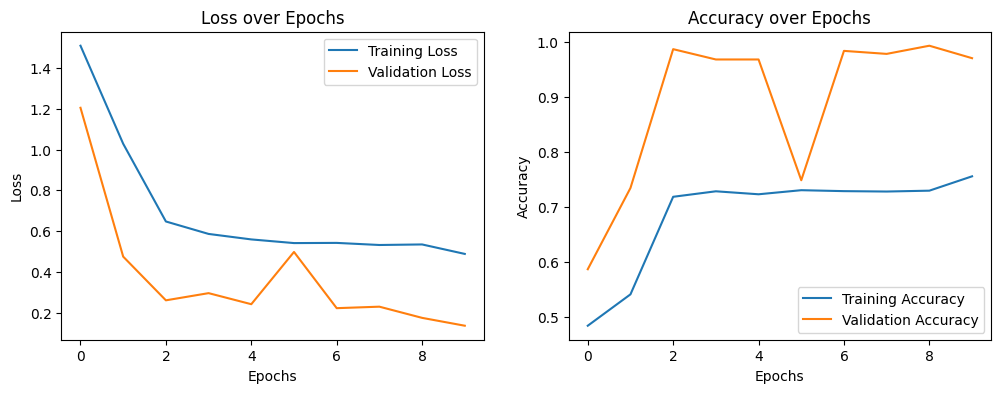

In [20]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

In [21]:
# 모델 예측
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_categorical, axis=1)

40/40 [==============================] - 3s 70ms/step


In [22]:
# 정확도 계산
from sklearn.metrics import accuracy_score # Import accuracy_score
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9710


In [23]:
# 정밀도 계산
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

Precision: 0.9748


In [24]:
# 재현율 계산
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

Recall: 0.9710


In [25]:
# F1 스코어 계산
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9708


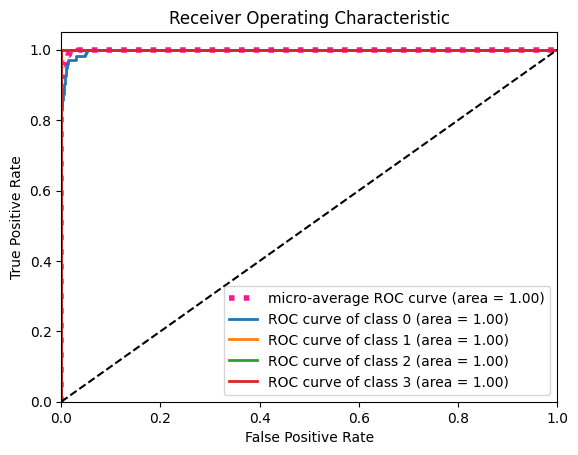

In [26]:
# ROC-AUC 계산 및 시각화
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_val_categorical[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 전체 ROC 커브
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_categorical.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(len(categories)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
# 정밀도-재현율 곡선 계산 및 시각화
precision = {}
recall = {}
pr_auc = {}

for i in range(len(categories)):
    precision[i], recall[i], _ = precision_recall_curve(y_val_categorical[:, i], y_pred[:, i])
    pr_auc[i] = auc(recall[i], precision[i])


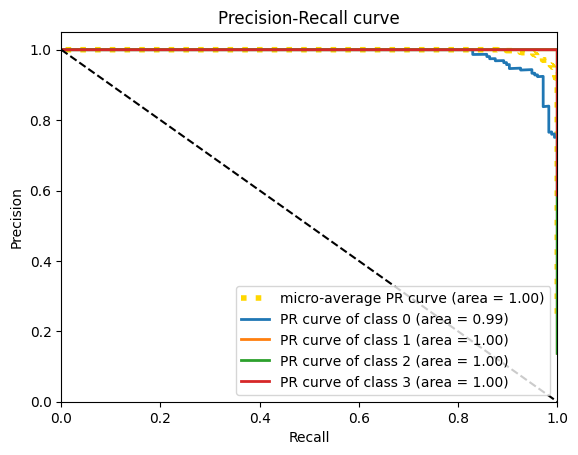

In [28]:
# 전체 PR 커브
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_categorical.ravel(), y_pred.ravel())
pr_auc["micro"] = auc(recall["micro"], precision["micro"])

plt.figure()
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4, label='micro-average PR curve (area = {0:0.2f})'.format(pr_auc["micro"]))
for i in range(len(categories)):
    plt.plot(recall[i], precision[i], lw=2, label='PR curve of class {0} (area = {1:0.2f})'.format(i, pr_auc[i]))

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# FLOPs 계산 함수
def get_flops(model):
    # 모델 입력 텐서를 정의
    if isinstance(model.input_shape, list):
        input_shape = model.input_shape[0]
    else:
        input_shape = model.input_shape

    inputs = [tf.TensorSpec([1] + list(input_shape[1:]), dtype=tf.float32)]

    # 모델을 함수형으로 변환
    concrete_function = tf.function(model).get_concrete_function(inputs)

    # 변환된 함수를 고정
    frozen_func = convert_variables_to_constants_v2(concrete_function)
    graph_def = frozen_func.graph.as_graph_def()

    # GraphDef를 임포트하여 새로운 그래프 생성
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')

        # 프로파일러 옵션 설정
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        # 세션을 사용하여 프로파일링
        with tf.compat.v1.Session(graph=graph) as sess:
            flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='scope', options=opts)

    return flops.total_float_ops


In [30]:
# 모델 플롭스 계산
flops = get_flops(model)
print(f"FLOPs: {flops:,}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPs: 383,800,412


In [31]:
# FLOPs 계산 함수
def get_flops(model):
    concrete_function = tf.function(lambda x: model(x))
    concrete_function = concrete_function.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype))

    frozen_func = convert_variables_to_constants_v2(concrete_function)
    frozen_graph = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(frozen_graph, name='')

        # 프로파일링을 위한 런 옵션 설정
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        # 세션을 사용하여 프로파일링
        with tf.compat.v1.Session(graph=graph) as sess:
            flops = tf.compat.v1.profiler.profile(graph=graph, options=opts)

    return flops.total_float_ops

In [32]:
# 모델 플롭스 계산
flops = get_flops(model)
print(f"FLOPs: {flops:,}")

FLOPs: 383,800,412
